<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/04_SpeechTimeSeries/examples/multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Time Series RNN examples

This example shows how a multi-variate time series can be trained using LSTM:
 - How to restack multi-variate time series into 3d array
 - Applying a simple LSTM to predict the next value.
 - Applying an encoder-decoder LSTM to predict multiple next values.

For best results, run on a GPU (you can select GPU from Colab or setup your local machine with GPU). This notebook can also run on a CPU, but is slightly slower to train.

References:
 - https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
 - https://towardsdatascience.com/time-series-forecasting-with-deep-stacked-unidirectional-and-bidirectional-lstms-de7c099bd918

Dataset: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
# Run this cell if you are using Colab, otherwise you can skip it
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# to address a warning on implicit datetime conversion
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_style('whitegrid')
%matplotlib inline

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [0]:
# Read data from UCI repository
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [4]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
2010-01-01 00:00:00,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [6]:
df.drop(['No', 'year', 'month', 'day', 'hour'], axis=1, inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [8]:
# need to figure out which rows are empty so that we can interpolate or something

# let's create a temporary dataframe to use for marking the empty values
empty = df[df.isna().any(axis=1)].copy()
empty

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-20 12:00:00,NaN,-18,0.0,1030.0,NW,244.97,0,0
2014-12-20 13:00:00,NaN,-19,1.0,1029.0,NW,249.89,0,0
2014-12-20 14:00:00,NaN,-20,1.0,1029.0,NW,257.04,0,0
2014-12-20 15:00:00,NaN,-20,2.0,1028.0,NW,262.85,0,0


In [0]:
# fill in with some value that we will use as a marker
empty.fillna('1000', inplace=True)

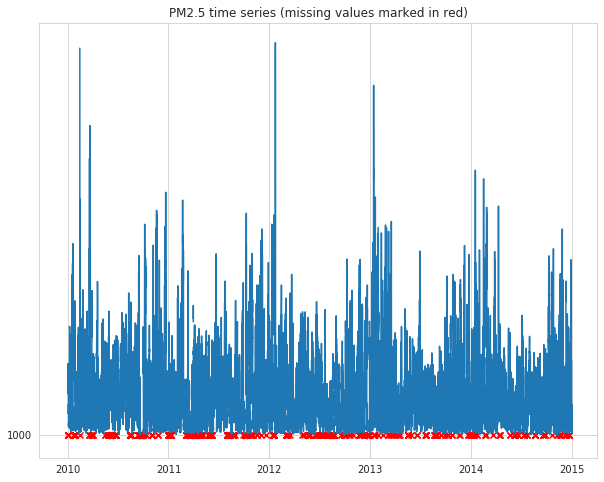

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df['pm2.5'])

# mark the rows that are NaN
ax.scatter(empty.index, empty['pm2.5'], marker='x', color='red')

ax.set_title('PM2.5 time series (missing values marked in red)')

plt.show()

In [0]:
# empty values are everywhere :(, so we have to do some forward filling

df.ffill(inplace=True)

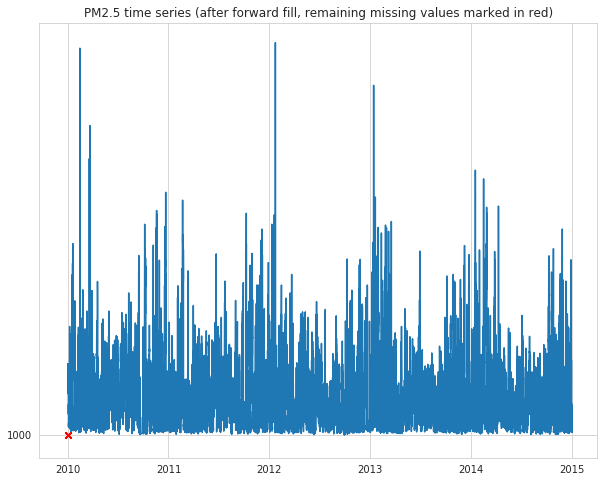

In [12]:
empty = df[df.isna().any(axis=1)].copy()

# fill in with some value that we will use as a marker
empty.fillna('1000', inplace=True)

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df['pm2.5'])

# mark the rows that are NaN
ax.scatter(empty.index, empty['pm2.5'], marker='x', color='red')

ax.set_title('PM2.5 time series (after forward fill, remaining missing values marked in red)')

plt.show()

In [0]:
# let's drop the remaining entries as they are only a few at the beginning of the dataframe

df.dropna(inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pm2.5    43800 non-null float64
DEWP     43800 non-null int64
TEMP     43800 non-null float64
PRES     43800 non-null float64
cbwd     43800 non-null object
Iws      43800 non-null float64
Is       43800 non-null int64
Ir       43800 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


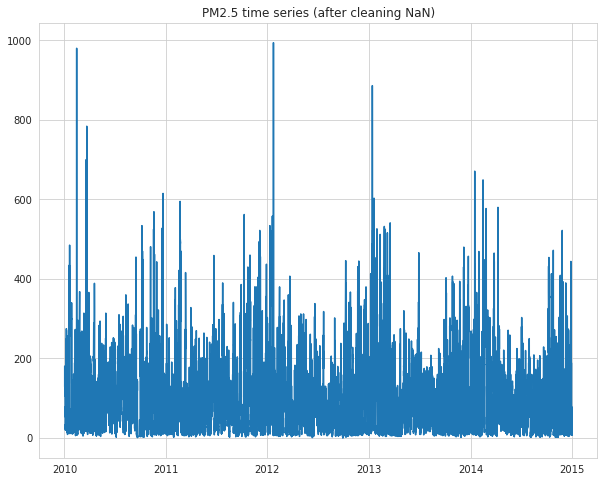

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df['pm2.5'])

ax.set_title('PM2.5 time series (after cleaning NaN)')

plt.show()

In [16]:
df.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

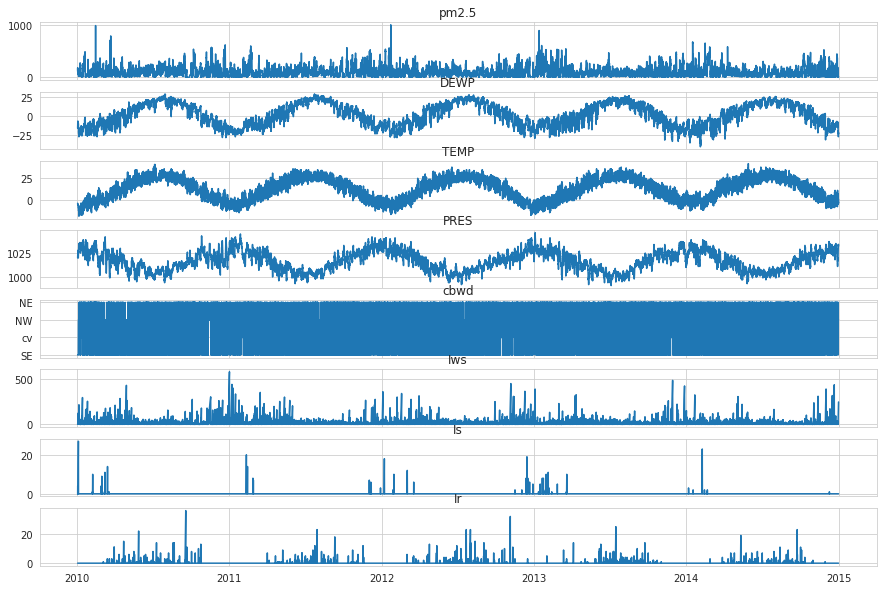

In [17]:
# plot the other columns in addition to the target

fig, ax = plt.subplots(nrows=len(df.columns), figsize=(15, 10), sharex=True)

for i in range(len(df.columns)):
  ax[i].plot(df[df.columns[i]])
  ax[i].set_title(df.columns[i])

plt.show()

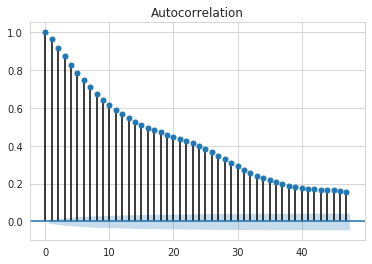

In [18]:
# Autocorrelation

plot_acf(df['pm2.5'])
plt.show()

PM2.5 is correlated to > 40 lags (hours). Let's try a 12 hour window to see if we can predict given past 1/2 day.

### Label encode cbwd

In [19]:
le = LabelEncoder()
df['cbwd_enc'] = le.fit_transform(df['cbwd'])
df.drop('cbwd', inplace=True, axis=1) # drop the raw column
df.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_enc
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,2
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,2
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,2
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,2
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,2


## Timeseries to supervised learning

Setup:
- columns: pm2.5[t-1], DEWP[t-1], TEMP[t-1], PRES[t-1], cbwd[t-1], Iws[t-1], Is[t-1], Ir[t-1]
- timesteps: 12 (hours). Note that we are not creating windows of these timesteps, but will be stacking into a 3-d array before training.
- target: pm2.5[t]


In [20]:
df_shifted = pd.concat([df, df['pm2.5'].shift(-1)], axis=1)
df_shifted.columns = ['pm2.5[t]',	'DEWP[t]', 'TEMP[t]', 'PRES[t]', 'Iws[t]', 'Is[t]', 'Ir[t]', 'cbwd_enc[t]', 'pm2.5[t+1]']
df_shifted.head()

,pm2.5[t],DEWP[t],TEMP[t],PRES[t],Iws[t],Is[t],Ir[t],cbwd_enc[t],pm2.5[t+1]
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,2,148.0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,2,159.0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,2,181.0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,2,138.0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,2,109.0


In [21]:
# drop the last row
df_shifted.dropna(inplace=True)
df_shifted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43799 entries, 2010-01-02 00:00:00 to 2014-12-31 22:00:00
Data columns (total 9 columns):
pm2.5[t]       43799 non-null float64
DEWP[t]        43799 non-null int64
TEMP[t]        43799 non-null float64
PRES[t]        43799 non-null float64
Iws[t]         43799 non-null float64
Is[t]          43799 non-null int64
Ir[t]          43799 non-null int64
cbwd_enc[t]    43799 non-null int64
pm2.5[t+1]     43799 non-null float64
dtypes: float64(5), int64(4)
memory usage: 3.3 MB


43799 is an odd number. Let's make it divisible by 12 so that we can use timesteps=12 (12 hours)

In [22]:
timesteps = 12

remainder = len(df_shifted)%timesteps
remainder

11

In [23]:
# since we want to predict the future, let's drop the first 11 rows
indices = df_shifted.index[:remainder]
print(len(indices))

df_shifted_divisible = df_shifted.drop(indices)
df_shifted_divisible.info()

11
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43788 entries, 2010-01-02 11:00:00 to 2014-12-31 22:00:00
Data columns (total 9 columns):
pm2.5[t]       43788 non-null float64
DEWP[t]        43788 non-null int64
TEMP[t]        43788 non-null float64
PRES[t]        43788 non-null float64
Iws[t]         43788 non-null float64
Is[t]          43788 non-null int64
Ir[t]          43788 non-null int64
cbwd_enc[t]    43788 non-null int64
pm2.5[t+1]     43788 non-null float64
dtypes: float64(5), int64(4)
memory usage: 3.3 MB


In [24]:
# check again, remainder should be 0
remainder = len(df_shifted_divisible)%timesteps
remainder

0

### Create X and y

Since we know the last column is 'pm2.5[t+1]' (our target), we can create
X and y using numpy indexing. 

Recall that .values returns the numpy array for a DataFrame

In [25]:
X = df_shifted_divisible.values[:, :-1] # all except last column
y = df_shifted_divisible.values[:, -1] # last column

X.shape, y.shape

((43788, 8), (43788,))

### Reshaping for RNN

We will create a 3-d array, where each row is a block of timesteps, features.
Basically, we are training a model to predict the pm2.5 based on last 12 hours of features.

Conceptually, consider a 3D-cube:
- Dimension 1: features (variables)
- Dimension 2: values (at a given hour)
- Dimension 3: time (12 hours)

Inspiration (np.take): https://towardsdatascience.com/time-series-forecasting-with-deep-stacked-unidirectional-and-bidirectional-lstms-de7c099bd918

In [26]:
# rolling window of indices
timesteps = 12

rolling_seq_idxs = [(range(i, i+timesteps)) for i in range(X.shape[0]-timesteps)]

# np.take is much faster than doing a rolling window across 43k rows and
# stacking row-wise
X_seq = np.take(X, rolling_seq_idxs, axis=0)
X_seq.shape # 3-d dataset (num_rows, timesteps, features)

(43776, 12, 8)

In [27]:
# inspect first timesteps+1 values
X[:timesteps+1]

array([[ 1.520e+02, -8.000e+00, -5.000e+00,  1.026e+03,  2.056e+01,
         0.000e+00,  0.000e+00,  2.000e+00],
       [ 1.480e+02, -8.000e+00, -5.000e+00,  1.026e+03,  2.369e+01,
         0.000e+00,  0.000e+00,  2.000e+00],
       [ 1.640e+02, -8.000e+00, -5.000e+00,  1.025e+03,  2.771e+01,
         0.000e+00,  0.000e+00,  2.000e+00],
       [ 1.580e+02, -9.000e+00, -5.000e+00,  1.025e+03,  3.173e+01,
         0.000e+00,  0.000e+00,  2.000e+00],
       [ 1.540e+02, -9.000e+00, -5.000e+00,  1.025e+03,  3.575e+01,
         0.000e+00,  0.000e+00,  2.000e+00],
       [ 1.590e+02, -9.000e+00, -5.000e+00,  1.026e+03,  3.754e+01,
         0.000e+00,  0.000e+00,  2.000e+00],
       [ 1.640e+02, -8.000e+00, -5.000e+00,  1.027e+03,  3.933e+01,
         0.000e+00,  0.000e+00,  2.000e+00],
       [ 1.700e+02, -8.000e+00, -5.000e+00,  1.027e+03,  4.246e+01,
         0.000e+00,  0.000e+00,  2.000e+00],
       [ 1.490e+02, -8.000e+00, -5.000e+00,  1.028e+03,  4.425e+01,
         0.000e+00,  0.000e+

In [28]:
# inspect the first 2 rows
X_seq[:2]

array([[[ 1.520e+02, -8.000e+00, -5.000e+00,  1.026e+03,  2.056e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.480e+02, -8.000e+00, -5.000e+00,  1.026e+03,  2.369e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.640e+02, -8.000e+00, -5.000e+00,  1.025e+03,  2.771e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.580e+02, -9.000e+00, -5.000e+00,  1.025e+03,  3.173e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.540e+02, -9.000e+00, -5.000e+00,  1.025e+03,  3.575e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.590e+02, -9.000e+00, -5.000e+00,  1.026e+03,  3.754e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.640e+02, -8.000e+00, -5.000e+00,  1.027e+03,  3.933e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.700e+02, -8.000e+00, -5.000e+00,  1.027e+03,  4.246e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.490e+02, -8.000e+00, -5.000e+00,  1.028e+03,  4.425e+01,
          0

In [29]:
# shift y down by timesteps (to match the number of rows of X_new)
# the first entry of y should be the prediction after t timesteps

y_seq = y[timesteps:]
y_seq.shape # should be same number of rows as X_seq

(43776,)

### Train-test split

We don't shuffle because we want to keep the last entries for backtesting.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq,
                                                    test_size=0.2,
                                                    shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35020, 12, 8), (8756, 12, 8), (35020,), (8756,))

### Min-max scaling

We fit two scalers:
* X scaler
* y scaler

sklearn's MinMaxScaler only accepts dimensions <= 2, so we do some reshaping of the data before scaling, and restore to the original shape after scaling.

In [31]:
# convert from 3D to 2D
X_train_temp = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_train_temp.shape

(35020, 96)

In [32]:
# convert from 2D to 3D
X_train_temp2 = X_train_temp.reshape(-1, X_train.shape[1], X_train.shape[2])
X_train_temp2.shape

(35020, 12, 8)

In [0]:
# check that the restoring worked
# we can compare the values here because we didn't scale
assert(np.array_equal(X_train, X_train_temp2))

In [0]:
X_scaler = MinMaxScaler(feature_range=(-1,1))
y_scaler = MinMaxScaler(feature_range=(-1,1))

# X: reshape to 2D, scale, restore to 3D
X_train_temp = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_train_sc = X_scaler.fit_transform(X_train_temp)
X_train_sc = X_train_sc.reshape(-1, X_train.shape[1], X_train.shape[2])

X_test_temp = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])
X_test_sc = X_scaler.transform(X_test_temp)
X_test_sc = X_test_sc.reshape(-1, X_test.shape[1], X_test.shape[2])

# y: expand to 2D, scale (no need to restore because 2nd dimension is 1)
y_train_sc = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_sc = y_scaler.transform(y_test.reshape(-1, 1))

In [35]:
X_train_sc[:2] # inspect first 2 values

array([[[-0.69416499, -0.18032787, -0.53333333,  0.27272727,
         -0.93126549, -1.        , -1.        ,  0.33333333],
        [-0.70221328, -0.18032787, -0.53333333,  0.27272727,
         -0.92056738, -1.        , -1.        ,  0.33333333],
        [-0.67002012, -0.18032787, -0.53333333,  0.23636364,
         -0.90682731, -1.        , -1.        ,  0.33333333],
        [-0.68209256, -0.21311475, -0.53333333,  0.23636364,
         -0.89308724, -1.        , -1.        ,  0.33333333],
        [-0.69014085, -0.21311475, -0.53333333,  0.23636364,
         -0.87934718, -1.        , -1.        ,  0.33333333],
        [-0.68008048, -0.21311475, -0.53333333,  0.27272727,
         -0.87322909, -1.        , -1.        ,  0.33333333],
        [-0.67002012, -0.18032787, -0.53333333,  0.30909091,
         -0.867111  , -1.        , -1.        ,  0.33333333],
        [-0.65794769, -0.18032787, -0.53333333,  0.30909091,
         -0.85641289, -1.        , -1.        ,  0.33333333],
        [-0.7002

In [36]:
y_train_sc[:2] # inspect first 2 values

array([[-0.81891348],
       [-0.87323944]])

## LSTM models

Let's try two models:
- Simple LSTM
- Encoder-Decoder LSTM, inspired by: https://towardsdatascience.com/time-series-forecasting-with-deep-stacked-unidirectional-and-bidirectional-lstms-de7c099bd918


### Simple LSTM

Input: (batch_size, timesteps, features)

Output: pm2.5[t]

In [37]:
# X_train is in the shape: num_rows, timesteps, features
features = X_train_sc.shape[2]

simple_lstm = Sequential()
simple_lstm.add(LSTM(50, input_shape=(timesteps, features)))
simple_lstm.add(Dense(1))
simple_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [0]:
simple_lstm.compile(loss='mae', optimizer='rmsprop')

In [0]:
# If running on Colab, note that this saves to temporary storage
# (cleaned up after ~6 hours). To persist to permanent storage, you can
# mount Google Drive and change the path to save to Google Drive.
mc = ModelCheckpoint('simple_lstm.h5', save_best_only=True)

In [40]:
# validation_data instead of validation_split is used because
# the latter will shuffle (unsafe for time series problems)
history = simple_lstm.fit(X_train_sc, y_train_sc, 
                          epochs=20,
                          validation_data=(X_test_sc, y_test_sc), callbacks=[mc])

Train on 35020 samples, validate on 8756 samples
Epoch 1/20
35020/35020 [==============================] - 10s 284us/sample - loss: 0.0732 - val_loss: 0.0459
Epoch 2/20
35020/35020 [==============================] - 7s 213us/sample - loss: 0.0487 - val_loss: 0.0457
Epoch 3/20
35020/35020 [==============================] - 7s 211us/sample - loss: 0.0443 - val_loss: 0.0393
Epoch 4/20
35020/35020 [==============================] - 7s 212us/sample - loss: 0.0427 - val_loss: 0.0377
Epoch 5/20
35020/35020 [==============================] - 7s 213us/sample - loss: 0.0419 - val_loss: 0.0422
Epoch 6/20
35020/35020 [==============================] - 7s 213us/sample - loss: 0.0413 - val_loss: 0.0510
Epoch 7/20
35020/35020 [==============================] - 7s 212us/sample - loss: 0.0409 - val_loss: 0.0402
Epoch 8/20
35020/35020 [==============================] - 7s 213us/sample - loss: 0.0406 - val_loss: 0.0409
Epoch 9/20
35020/35020 [==============================] - 8s 214us/sample - loss: 0.04

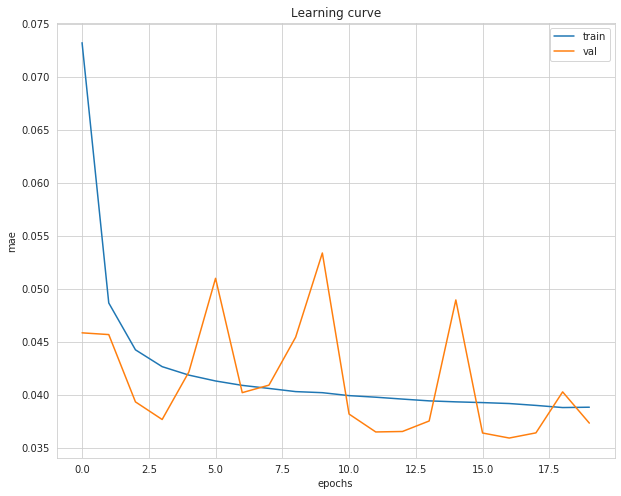

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')
ax.set_title('Learning curve')
ax.set_xlabel('epochs')
ax.set_ylabel('mae')
ax.legend()
plt.show()

In [42]:
# load best model (lowest validation loss)
best_simple_lstm = load_model('./simple_lstm.h5')
best_simple_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [43]:
# predict and unscale
y_pred = y_scaler.inverse_transform(best_simple_lstm.predict(X_test_sc))
y_pred

array([[52.533234],
       [56.555958],
       [84.59292 ],
       ...,
       [ 8.081915],
       [10.169217],
       [ 8.828427]], dtype=float32)

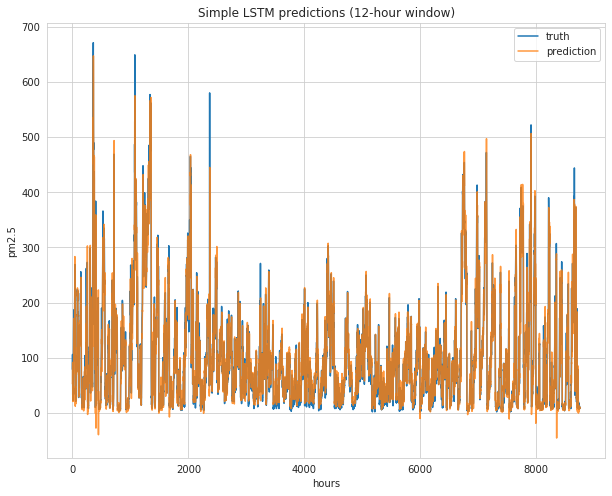

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(y_test, label='truth')
ax.plot(y_pred, label='prediction', alpha=0.8)
ax.set_title(f'Simple LSTM predictions ({timesteps}-hour window)')
ax.set_xlabel('hours')
ax.set_ylabel('pm2.5')
ax.legend()
plt.show()

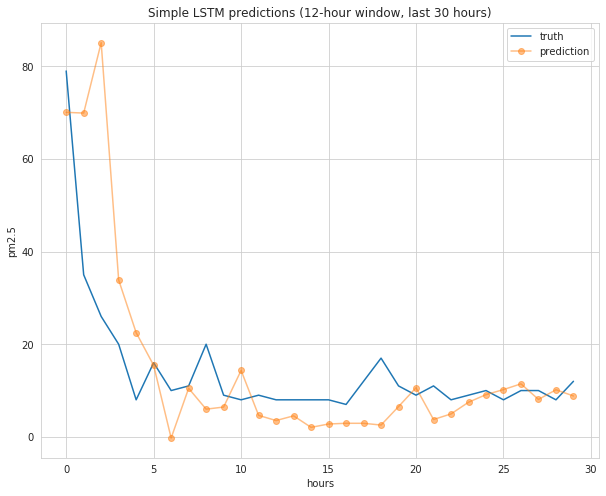

In [45]:
# hard to see, let's zoom in to the last few hours
N = 30

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(y_test[-N:], label='truth')
ax.plot(y_pred[-N:], label='prediction', alpha=0.5, marker='o')
ax.set_title(f'Simple LSTM predictions ({timesteps}-hour window, last {N} hours)')
ax.set_xlabel('hours')
ax.set_ylabel('pm2.5')
ax.legend()
plt.show()

Prediction seems to be laggard behind the actual values.

### Encoder-Decoder LSTM

In an encoder-decoder model, the output can be configured to any number of time steps. 

To illustrate this, we will use output_seq_len = 6. In other words, we will predict the next 6 hours based on the previous 12 hours of multi-variate features.

Input: (batch_size, timesteps, features)

Output: (batch_size, output_seq_len)

Notice that output is shifted twice, once for the input timesteps (12), and once for the output seq len (6)

In [46]:
X_seq.shape

(43776, 12, 8)

In [47]:
output_seq_len = 6 # predict 6 future values
offset = timesteps+output_seq_len # start y into the future

# rolling window of output indices
rolling_output_idxs = [(range(i, i+output_seq_len))
                        for i in range(offset,
                                       len(y)-offset)]

# np.take is much faster than doing a rolling window across 43k rows and
# stacking row-wise
Y_seq = np.take(y, rolling_output_idxs, axis=0)
Y_seq = Y_seq.reshape(-1, output_seq_len, 1)
Y_seq.shape # 2-d dataset (num_rows, timesteps, 1)

(43752, 6, 1)

In [48]:
y[offset:offset+output_seq_len+1] # first 7 future values for comparison

array([ 91.,  86.,  82.,  86.,  78.,  98., 107.])

In [49]:
Y_seq[:2] # first 2 rolling windows containing 7 future values: 0-6, 1-7, ...

array([[[ 91.],
        [ 86.],
        [ 82.],
        [ 86.],
        [ 78.],
        [ 98.]],

       [[ 86.],
        [ 82.],
        [ 86.],
        [ 78.],
        [ 98.],
        [107.]]])

In [50]:
X_seq[:2] # first 2 rolling windows of input features

array([[[ 1.520e+02, -8.000e+00, -5.000e+00,  1.026e+03,  2.056e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.480e+02, -8.000e+00, -5.000e+00,  1.026e+03,  2.369e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.640e+02, -8.000e+00, -5.000e+00,  1.025e+03,  2.771e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.580e+02, -9.000e+00, -5.000e+00,  1.025e+03,  3.173e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.540e+02, -9.000e+00, -5.000e+00,  1.025e+03,  3.575e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.590e+02, -9.000e+00, -5.000e+00,  1.026e+03,  3.754e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.640e+02, -8.000e+00, -5.000e+00,  1.027e+03,  3.933e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.700e+02, -8.000e+00, -5.000e+00,  1.027e+03,  4.246e+01,
          0.000e+00,  0.000e+00,  2.000e+00],
        [ 1.490e+02, -8.000e+00, -5.000e+00,  1.028e+03,  4.425e+01,
          0

In [51]:
# drop the X_seq that has no future values of y
X_seq_dropna = X_seq[:Y_seq.shape[0]]
X_seq_dropna.shape

(43752, 12, 8)

#### Train-test split

In [52]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq_dropna,
                                                                    Y_seq,
                                                                    test_size=0.2, 
                                                                    shuffle=False)
X_train_seq.shape, X_test_seq.shape, y_train_seq.shape, y_test_seq.shape

((35001, 12, 8), (8751, 12, 8), (35001, 6, 1), (8751, 6, 1))

#### Scale

Similar to above, we'll fit 2 scalers, one for X and one for y.
The key difference is that now y is also 3D.

To reduce duplicate code, we'll use a function to do the 3D->2D->scale->3D conversion.


In [0]:
def apply_scaler_to_3D_data(data, scaler, fit=False, inverse=False):
  # reshape to 2D, scale, restore to 3D
  temp = data.reshape(-1, data.shape[1]*data.shape[2])
  if fit:
    scaler.fit(temp)
  if inverse:
    result = scaler.inverse_transform(temp)
  else:
    result = scaler.transform(temp)

  result = result.reshape(-1, data.shape[1], data.shape[2])
  return result, scaler

X_seq_scaler = MinMaxScaler(feature_range=(-1,1))
y_seq_scaler = MinMaxScaler(feature_range=(-1,1))

# X: reshape to 2D, scale, restore to 3D
X_train_seq_sc, X_seq_scaler = apply_scaler_to_3D_data(X_train_seq, X_seq_scaler, fit=True)
X_test_seq_sc, X_seq_scaler = apply_scaler_to_3D_data(X_test_seq, X_seq_scaler, fit=False)

# y: reshape to 2D, scale, restore to 3D
y_train_seq_sc, y_seq_scaler = apply_scaler_to_3D_data(y_train_seq, y_seq_scaler, fit=True)
y_test_seq_sc, y_seq_scaler = apply_scaler_to_3D_data(y_test_seq, y_seq_scaler, fit=False)

In [54]:
X_train_seq_sc[:2] # inspect some values

array([[[-0.69416499, -0.18032787, -0.53333333,  0.27272727,
         -0.93126549, -1.        , -1.        ,  0.33333333],
        [-0.70221328, -0.18032787, -0.53333333,  0.27272727,
         -0.92056738, -1.        , -1.        ,  0.33333333],
        [-0.67002012, -0.18032787, -0.53333333,  0.23636364,
         -0.90682731, -1.        , -1.        ,  0.33333333],
        [-0.68209256, -0.21311475, -0.53333333,  0.23636364,
         -0.89308724, -1.        , -1.        ,  0.33333333],
        [-0.69014085, -0.21311475, -0.53333333,  0.23636364,
         -0.87934718, -1.        , -1.        ,  0.33333333],
        [-0.68008048, -0.21311475, -0.53333333,  0.27272727,
         -0.87322909, -1.        , -1.        ,  0.33333333],
        [-0.67002012, -0.18032787, -0.53333333,  0.30909091,
         -0.867111  , -1.        , -1.        ,  0.33333333],
        [-0.65794769, -0.18032787, -0.53333333,  0.30909091,
         -0.85641289, -1.        , -1.        ,  0.33333333],
        [-0.7002

In [55]:
y_train_seq_sc[:2] # inspect some values

array([[[-0.81690141],
        [-0.82696177],
        [-0.83501006],
        [-0.82696177],
        [-0.84305835],
        [-0.8028169 ]],

       [[-0.82696177],
        [-0.83501006],
        [-0.82696177],
        [-0.84305835],
        [-0.8028169 ],
        [-0.78470825]]])

#### Model

This model is a modified version of the Keras Seq2Seq example:
https://keras.io/examples/lstm_seq2seq/

In [56]:
latent_dim = 50
output_features = 1

# Define an input sequence and process it.
encoder_inputs = Input(shape=(timesteps, features))
encoder = LSTM(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(output_seq_len, output_features))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# return sequences=True means that the output sequence will
# be returned as timesteps, with feature dimension 1
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(output_features)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
enc_dec_lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs)

enc_dec_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 8)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 50), (None,  11800       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 6, 50), (Non 10400       input_2[0][0]                    
                                                                 lstm_1[0][1]                 

In [0]:
enc_dec_lstm.compile(loss='mae', optimizer='rmsprop')

In [0]:
mc1 = ModelCheckpoint('enc_dec_lstm.h5', save_best_only=True)

In [59]:
# To train encoder-decoder, we need to provide an extra input
# for the decoder input data. Initialize this to zeros.
decoder_input_data = np.zeros(y_train_seq_sc.shape)
decoder_test_input_data = np.zeros(y_test_seq_sc.shape)

history1 = enc_dec_lstm.fit([X_train_seq_sc, decoder_input_data], y_train_seq_sc, 
                            epochs=20,
                            validation_data=([X_test_seq_sc, decoder_test_input_data],
                                             y_test_seq_sc),
                            callbacks=[mc1])

Train on 35001 samples, validate on 8751 samples
Epoch 1/20
35001/35001 [==============================] - 14s 408us/sample - loss: 0.1092 - val_loss: 0.0941
Epoch 2/20
35001/35001 [==============================] - 11s 320us/sample - loss: 0.0980 - val_loss: 0.1017
Epoch 3/20
35001/35001 [==============================] - 11s 326us/sample - loss: 0.0947 - val_loss: 0.0945
Epoch 4/20
35001/35001 [==============================] - 11s 323us/sample - loss: 0.0927 - val_loss: 0.0893
Epoch 5/20
35001/35001 [==============================] - 11s 316us/sample - loss: 0.0914 - val_loss: 0.0973
Epoch 6/20
35001/35001 [==============================] - 11s 318us/sample - loss: 0.0902 - val_loss: 0.0944
Epoch 7/20
35001/35001 [==============================] - 11s 317us/sample - loss: 0.0891 - val_loss: 0.0911
Epoch 8/20
35001/35001 [==============================] - 11s 319us/sample - loss: 0.0882 - val_loss: 0.0909
Epoch 9/20
35001/35001 [==============================] - 11s 317us/sample - lo

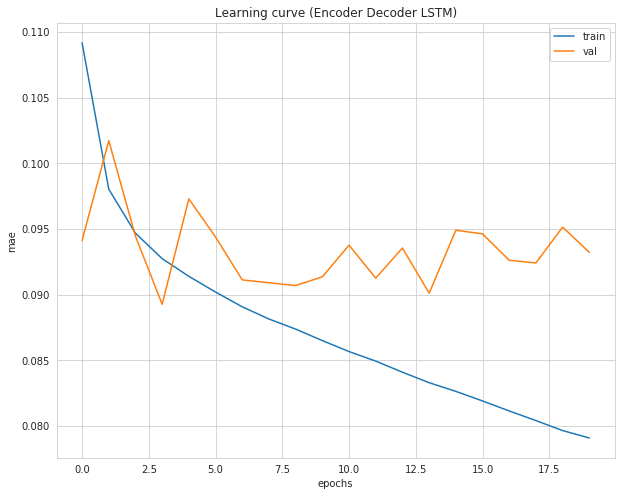

In [60]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(history1.history['loss'], label='train')
ax.plot(history1.history['val_loss'], label='val')
ax.set_title('Learning curve (Encoder Decoder LSTM)')
ax.set_xlabel('epochs')
ax.set_ylabel('mae')
ax.legend()
plt.show()

In [61]:
# load best model (lowest validation loss)
best_enc_dec_lstm = load_model('./enc_dec_lstm.h5')
best_enc_dec_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 8)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 50), (None,  11800       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 6, 50), (Non 10400       input_2[0][0]                    
                                                                 lstm_1[0][1]                 

In [0]:
# predict and unscale
# decoder_test_input_data is dummy (zeros)

y_pred_seq_sc = best_enc_dec_lstm.predict([X_test_seq_sc, decoder_test_input_data])
y_pred_seq, y_seq_scaler = apply_scaler_to_3D_data(y_pred_seq_sc, y_seq_scaler, 
                                                   fit=False, inverse=True)

In [63]:
y_pred_seq

array([[[34.654053],
        [28.194708],
        [27.978277],
        [27.423725],
        [27.041138],
        [26.552736]],

       [[33.927982],
        [27.706839],
        [28.213814],
        [27.996319],
        [27.832678],
        [27.487476]],

       [[34.543262],
        [28.440434],
        [29.225872],
        [29.083027],
        [28.954817],
        [28.62096 ]],

       ...,

       [[41.348907],
        [35.24279 ],
        [32.81541 ],
        [31.82809 ],
        [31.42287 ],
        [31.016317]],

       [[31.618711],
        [27.43054 ],
        [26.435635],
        [26.381897],
        [26.669363],
        [26.800655]],

       [[25.026266],
        [22.503408],
        [22.58597 ],
        [23.316605],
        [24.170473],
        [24.718685]]], dtype=float32)

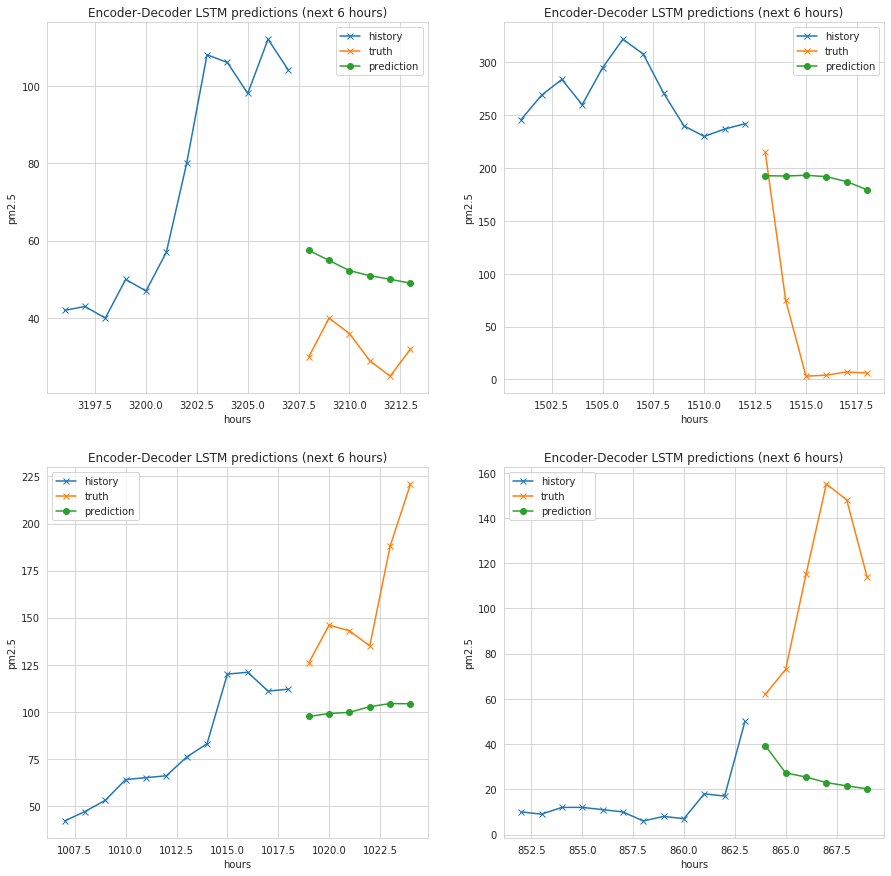

In [64]:
# Since we are predicting 6 hours at a time, we'll create a few plots
# at different time points

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axes = axes.flatten()

indices = np.random.choice(len(X_test_seq), 4)
for i, ax in zip(indices, axes):
  x = np.arange(i, timesteps+output_seq_len+i)

  # the plots will look disconnected because we are plotting them
  # in 3 separate sequences
  ax.plot(x[:timesteps], X_test_seq[i, :, 0].ravel(), label='history', marker='x')  
  ax.plot(x[timesteps:], y_test_seq[i], label='truth', marker='x')
  ax.plot(x[timesteps:], y_pred_seq[i], label='prediction', marker='o')

  ax.set_title(f'Encoder-Decoder LSTM predictions (next {output_seq_len} hours)')
  ax.set_xlabel('hours')
  ax.set_ylabel('pm2.5')
  ax.legend()
plt.show()

From a random sampling above, we can see that the predicted sequence tends to follow the actual trend at the beginning of the output sequence, but diverges quickly if the actual trend diverges.

Similar to simple LSTM, the predictions tend to be "smoothed" out versions than actual.

A way to improve is to reduce the output sequence window sizes, or include the first part of the output sequence as a feature.


## Summary

RNNs (LSTM, Vanilla or GRU) can be a powerful technique for learning data that has a time dimension, and using that to predict future values. 

A key advantage over ARIMA models, as demonstrated here, is the RNN's ability to learn multiple input variables.

RNNs tend to produce a "smoothed" out  prediction. Therefore, selecting the window size (how much the RNN will move backward/forward in time) will determine how much smoothing will occur. Larger window sizes tend to produce more averaging effects.